## Introduction
Data science, and particularly machine learning, contain many dimensions of complexity when compared with standard software development. In standard software development, code not working as we expect can be caused by a number of factors along two dimensions:

- Bugs in implementation
- Algorithm design
Machine learning problems, have many more dimensions:

- Bugs in implementation
- Algorithm design
- Model issues
- Data quality
The result of this is that there are exponentially more places that machine learning can go wrong

<img src= 'why-is-ml-hard.png'>
This concept is shown in the diagram above (taken from the excellent post Why is machine learning 'hard'?). The green dot is a 'correct' solution, where the red dots are incorrect solutions. In this illustration there are only a small number of incorrect combinations for software engineering, but in machine learning this becomes exponentially greater!

By defining a workflow for ourself, we can give ourself a framework with which to make iterating on ideas quicker and easier, allowing ourself to work more efficiently.

In this lesson, we're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Loading Dataset and external files

In [3]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [4]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The **%load** command will copy the contents of the file into the current notebook cell. (The load gets commented out itself)

In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
def preprocessing(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for col in ['Age_categories','Fare_categories',
                'Title','Cabin_type','Sex']:
        df = create_dummies(df, col)
    
    return df

In [7]:
train = preprocessing(train)
holdout = preprocessing(holdout)

## Data Exploration

#### Lets explore the columns of describing family members
*SibSp* and *Parch*

In [8]:
family_members = ['SibSp', 'Parch', 'Survived']
family_members_df = train[family_members]

In [9]:
for col in family_members_df:
    print(train[col].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
0    549
1    342
Name: Survived, dtype: int64


In [10]:
family_members_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


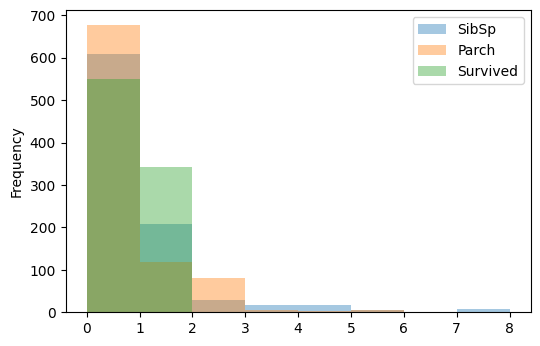

In [11]:
family_members_df.plot.hist(alpha=0.4, bins=8)

<ipython-input-12-99f63899ac9d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



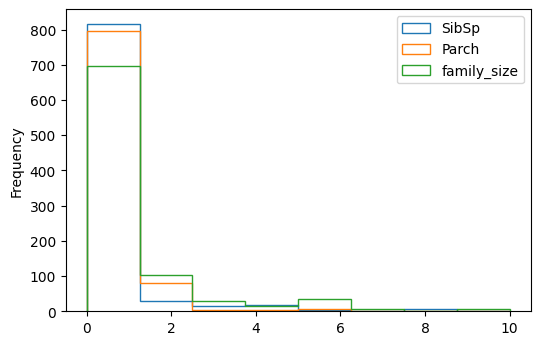

In [12]:
family_members_df['family_size'] = family_members_df[['SibSp',
                                                      'Parch']].sum(axis=1)
family_members_df.drop('Survived', axis=1).plot.hist(bins=8,histtype='step')

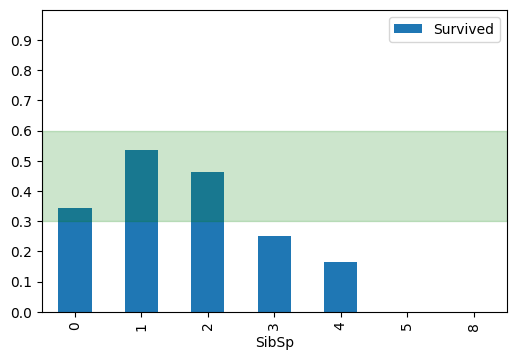

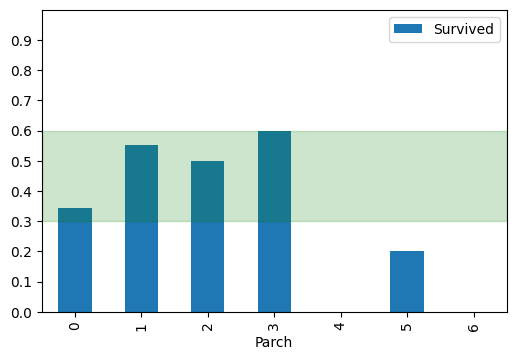

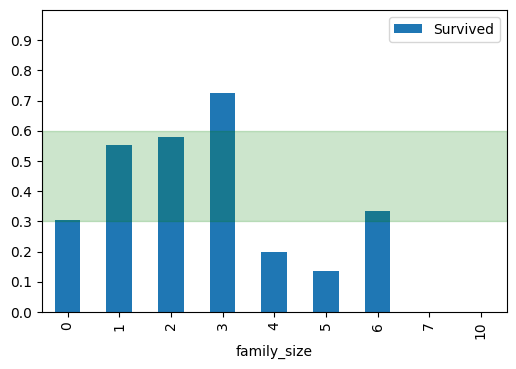

In [13]:
for col in family_members_df.columns.drop("Survived"):
    pivot = family_members_df.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='green')
    plt.show()

Combining the values of SibSp and Parch into a single column, only 30% of the passengers who had no family members onboard survived

In [14]:
def isalone(df):
    df['family_size'] = df[['SibSp', 'Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['family_size'] == 0), 'isalone'] = 1 
    return df

In [15]:
train = isalone(train)
holdout = isalone(holdout)

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,family_size,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,1,0,1,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,1,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,1,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,1,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,1,0,1,0,1


In [17]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male,family_size,isalone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,0,0,0,1,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,0,0,1,1,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,1,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,0,0,0,0,0,1,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,0,0,0,0,0,1,1,0,2,0


## Feature Selection

In [18]:
def select_feature(df):
    df = df.select_dtypes(exclude = ['category','object']).dropna()
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    
    rf_cls = RandomForestClassifier(random_state=1)
    auto_selector = RFECV(rf_cls, cv=10)
    auto_selector.fit(all_X, all_y)
    
    # best performing features
    select_features = all_X.columns[auto_selector.support_]
    print('Best columns:', '\n', select_features)
    
    return select_features
    

In [19]:
selected_features = select_feature(train)

Best columns: 
 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'family_size'],
      dtype='object')


## Model Selection

In [45]:
def select_model(df, features, target):
    all_X = df[features]
    all_y = df[target]
    models = [
        {'name': 'LogisticRegression',
        'estimator': LogisticRegression(),
        'hyperparameters': 
        {'solver': ['newton-cg', 'lbfgs', 'liblinear']
        }},
        {'name': 'KNeighborsClassifier',
        'estimator': KNeighborsClassifier(),
        'hyperparameters':
        {'n_neighbors': range(1,20,2),
        'weights': ['distance', 'uniform'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'p': [1,2]
        }},
        {'name': 'RandomForestClassifier',
        'estimator': RandomForestClassifier(),
        'hyperparameters': 
        {'n_estimators': [4,6,9],
        'criterion': ['entropy', 'gini'],
        'max_depth': [2,5,10],
        'max_features': ['log2', 'sqrt'],
        'min_samples_leaf': [1,5,8],
        'min_samples_split': [2,3,5]
        }}
    ]

    for model in models:
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_

        print(model['name'])

        print('Best Parameters: {}'.format(model['best_params']))
        print('Best Score: {}'.format(model['best_score']))
        print('\n')
    return models
    

In [46]:
results = select_model(train, selected_features, 'Survived')

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

LogisticRegression
Best Parameters: {'solver': 'newton-cg'}
Best Score: 0.821598002496879


KNeighborsClassifier
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Best Score: 0.7822971285892635


RandomForestClassifier
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}
Best Score: 0.8362047440699125




## Making a Submission to Kaggle

In [50]:
def save_submission_file(model, columns, filename="submission.csv"):
    holdout_data = holdout[columns]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)
    return submission
    



In [52]:
pick_rf_model = results[2]["best_model"]
save_submission_file(pick_rf_model, selected_features)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
